In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '3'

In [2]:
# Importing the libraries:
import tensorflow as tf
from tensorflow import keras
import numpy as np
tf.__version__, keras.__version__, tf.config.list_physical_devices("GPU")

('2.10.0',
 '2.10.0',
 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

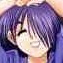

In [3]:
# Testing image data:
data_dir = r'images/0_2000.jpg'
Load_image = tf.keras.preprocessing.image.load_img(data_dir)
Load_image

# Prepping the Images:

In [4]:
# Creating a set of transformations for images:
@tf.function
def transform(image):
    img = tf.image.resize_with_crop_or_pad(image, 100, 100)
    img = img/255.
    return img

In [5]:
# Creating a function to automate image loading:
def load_img(path = os.path.join("images")):
    all_img = os.listdir(path)
    list = []
    j = 0
    for i in all_img:
        cur_img = tf.keras.preprocessing.image.load_img(os.path.join(path, i))
        app_img = tf.keras.preprocessing.image.img_to_array(cur_img)
        img = transform(app_img)
        list.append(img)
        j += 1
        if j == 10000:
            return np.array(list, dtype = np.float32)

In [6]:
data = load_img()

In [7]:
# Creating a image plotter:
def plot(x_train, y, image_no = 1):
    for i in tf.range(image_no):
        img = x_train[y]
        img = tf.keras.preprocessing.image.array_to_img(img)
        img.show()
        img.save(f"Saved Pictures/progress{y}.jpg")


In [8]:
# Plotting an image:
plot(data, 0)

In [9]:
# Creating an easy dataset:
x_train = tf.data.Dataset.from_tensor_slices(data).batch(32, drop_remainder = True).shuffle(1000)
batch_size = 32

In [10]:
# Creating some more variables:
coding_size = 100
optimizer = tf.keras.optimizers.Nadam()
loss = tf.keras.losses.binary_crossentropy

# Creating a GAN:

In [11]:
# Sequential generator:
generator = keras.models.Sequential([
    keras.layers.Dense(25 * 25 * 128, input_shape = [coding_size]),
    keras.layers.Reshape([25, 25, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size = 5, strides = 2, padding = "same", activation = 'selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(3, kernel_size = 5, strides = 2, padding = "same", activation = "tanh")
])

In [12]:
# Sequential discriminator:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size = 5, strides  = 2, padding = "same", activation = keras.layers.LeakyReLU(0.2), input_shape = [100, 100, 3]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size = 5, strides = 2, padding = "same", activation = keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation = "sigmoid")
])

In [13]:
# Creating a gan:
gan = keras.models.Sequential([generator, discriminator])

# Training the GAN:

In [14]:
# General Step:
def train_step(model, x, y, loss_fn = loss, optimizer = optimizer):
    with tf.GradientTape() as tape:
        y_pred = model(x)
        loss = loss_fn(y_pred = y_pred, y_true = y)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [15]:
#  Discriminator step:
@tf.function
def train_d(model, noise, x_batch, batch_size = batch_size):
    generator, discriminator = model.layers
    predictions = generator(noise)
    inputs = tf.concat([predictions, x_batch], axis = 0)
    y = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
    discriminator.trainable = True
    train_step(discriminator, inputs, y)

In [16]:
# Generator step:
@tf.function
def train_g(model, noise, x_batch, batch_size = batch_size):
    discriminator = model.layers[1]
    discriminator.trainable = False
    y = tf.constant([[1.]] * batch_size)
    train_step(model, noise, y)

In [17]:
# Predicting values:
def predict(model, epoch, batch_size = batch_size, coding_size = coding_size):
    noise = tf.random.normal([batch_size, coding_size])
    generator = model.layers[0]
    predictions = generator(noise)
    plot(predictions, epoch)

In [18]:
# Training Loop:
epochs = 100
for epoch in range(epochs):
    for x_batch in x_train:
        # Training the Discriminator:
        noise = tf.random.normal([batch_size, coding_size])
        train_d(gan, noise, x_batch)
        # Training the Generator:
        noise = tf.random.normal([batch_size, coding_size])
        train_g(gan, noise, x_batch)
    print(f"Epochs {epoch + 1} passed.")
    predict(gan, epoch + 1)

Epochs 1 passed.
Epochs 2 passed.
Epochs 3 passed.
Epochs 4 passed.
Epochs 5 passed.
Epochs 6 passed.
Epochs 7 passed.
Epochs 8 passed.
Epochs 9 passed.
Epochs 10 passed.
